# GemPy Paper Code: Likelihoods

In this notebook you will be able to see and run the code utilized to create the figures of the paper *GemPy - an open-source library for implicit geological modeling and uncertainty quantification*

In [1]:
# Importing dependencies

# These two lines are necessary only if gempy is not installed
import sys, os
sys.path.append("../..")
import gempy as gp
%matplotlib inline
from copy import copy, deepcopy
# Aux imports

import numpy as np
import pandas as pn
import matplotlib.pyplot as plt

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Uncertainty Quatification.

In this model we will explore how to create a model of GemPy with PyMC which some of the parameters are stochastic  in order to quatify the uncertainty that those parameters propagate to the final results.

We will use the same model as until now

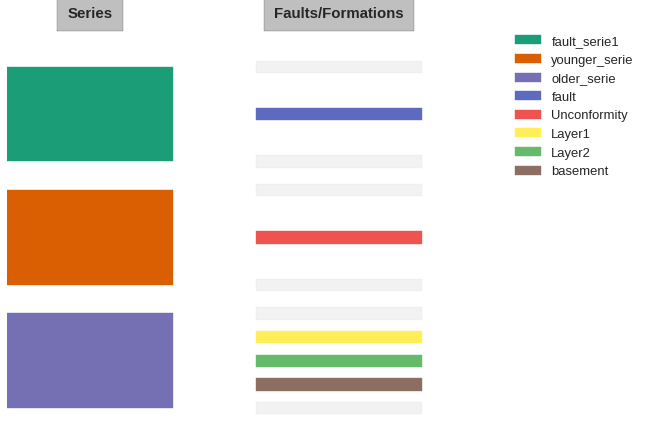

In [39]:

geo_data = gp.create_data([-10e3,30e3,-10e3,20e3,-10e3,0],[100,50,50],
                         path_o = "input_data/paper_Orientations.csv",
                         path_i = "input_data/paper_Points.csv")
#geo_data.add_interface(X=10, Y=4, Z=-7, formation='fault1')

gp.set_series(geo_data, {'fault_serie1': 'fault','younger_serie' : 'Unconformity', 'older_serie': ('Layer1', 'Layer2')},
              order_formations= ['fault', 'Unconformity', 'Layer2', 'Layer1'], verbose=2)

#geo_data.modify_interface(9, Z = -6.4)

In [40]:
geo_data.interfaces[['X', 'Y', 'Z']] = geo_data.interfaces[['X', 'Y', 'Z']]*1000
geo_data.orientations[['X', 'Y', 'Z']] = geo_data.orientations[['X', 'Y', 'Z']]*1000

../../gempy/gempy_front.py:927: FutureWarning: gempy plotting functionality will be moved in version 1.2, use gempy.plotting module instead
  warnings.warn("gempy plotting functionality will be moved in version 1.2, use gempy.plotting module instead", FutureWarning)


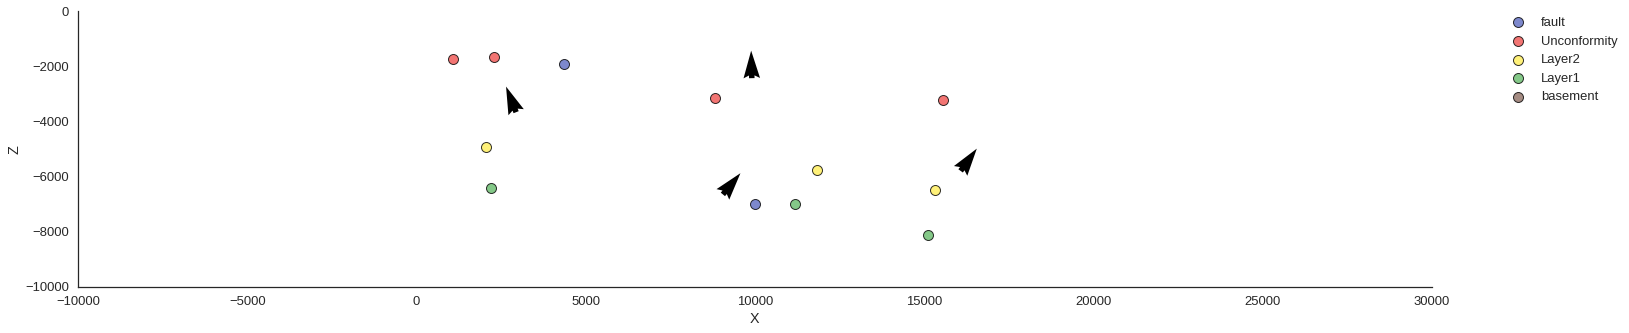

In [41]:
gp.plot_data(geo_data, direction="y")

Defining all different series that form the most complex model. In the paper you can find figures with different combination of these series to examplify the possible types of topolodies supported in GemPy

In [42]:
interp_data = gp.InterpolatorData(geo_data, dtype='float64', output='gravity', compile_theano=True)

Compiling theano function...
Compilation Done!
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  1


In [43]:
# Set the specific parameters for the measurement grid of gravity:
gp.set_geophysics_obj(interp_data,  
                      [0.1e3,19.9e3,.1e3,.9e3, -10e3, 0], # Extent
                      [30,20])                            # Resolution 

In [44]:
# Setting desity and precomputations 
t = gp.precomputations_gravity(interp_data, 25,
                         [2.92e6, 3.1e6, 2.61e6, 2.92e6])

Computing the model

In [45]:
lith, fault, grav_i = gp.compute_model(interp_data, output='gravity')

## Topology

compute the initial topology for use in the topology likelihood function

../../gempy/gempy_front.py:953: FutureWarning: gempy plotting functionality will be moved in version 1.2, use gempy.plotting module instead
  "use gempy.plotting module instead", FutureWarning)


AttributeError: module 'gempy' has no attribute 'topology_plot'

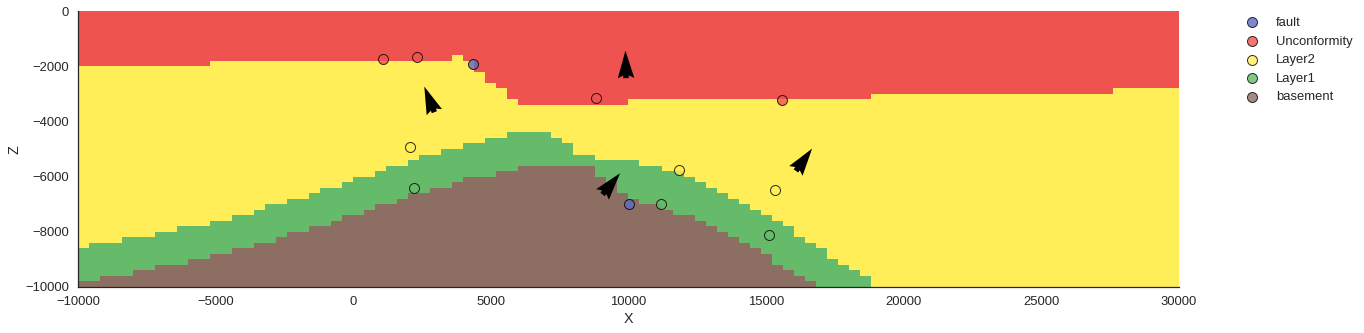

In [46]:
topo = gp.topology_compute(geo_data, lith[0], fault)
gp.plot_section(geo_data, lith[0],20, plot_data=True, direction='y')
gp.topology_plot(geo_data, topo[0], topo[1])
# plt.xlim(0, 19000)
# plt.ylim(-10000, 0)
# save topology state for likelihood use
topo_G = copy(topo[0])

## Gravity

../../gempy/gempy_front.py:953: FutureWarning: gempy plotting functionality will be moved in version 1.2, use gempy.plotting module instead
  "use gempy.plotting module instead", FutureWarning)


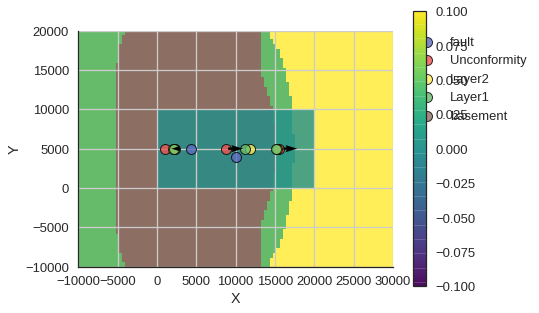

In [47]:
gp.plot_section(geo_data, lith[0], 5, direction='z',plot_data=True)
#annotate_plot(gp.get_data(geo_data_g, verbosity=2), 'annotations', 'X', 'Z', size = 20)
# ax = plt.gca()
# ax.set_xticks(np.linspace(0, 20, 50))
# ax.set_yticks(np.linspace(0, -10, 50))
plt.grid()
fig = plt.gcf()
ax = plt.gca()
p = ax.imshow(grav_i.reshape(20,30), cmap='viridis', origin='lower', alpha=0.8, extent=[0,20e3,0,10e3])
# plt.xlim(-2e3,22e3)
# plt.ylim(-2e3,12e3)

plt.xlim(-10e3,30e3)
plt.ylim(-10e3,20e3)

plt.colorbar(p)
#plt.show()

../../gempy/gempy_front.py:927: FutureWarning: gempy plotting functionality will be moved in version 1.2, use gempy.plotting module instead
  warnings.warn("gempy plotting functionality will be moved in version 1.2, use gempy.plotting module instead", FutureWarning)


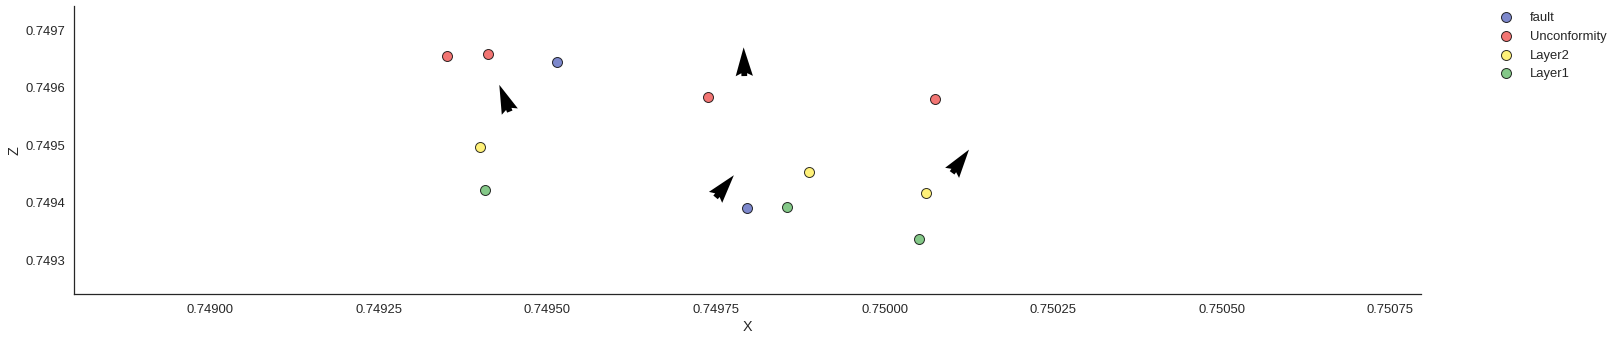

In [49]:
gp.plot_data(interp_data.geo_data_res)

In [10]:
original_grav = np.load('input_data/real_grav.npy')

In [15]:
diff = original_grav*10**-7 - grav_i*10**-7

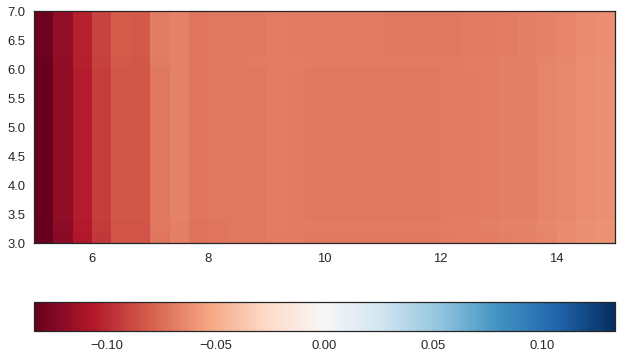

In [17]:
plt.imshow(diff.reshape(20,30), cmap='RdBu', origin='lower', extent=[5,15,3,7], vmin = diff.min(),
           vmax=-diff.min())
plt.colorbar(orientation='horizontal')

# PYMC2 Code

In [18]:
import pymc

## Priors

In [19]:
geo_data.interfaces.head()

,X,Y,Z,formation,series,order_series,isFault,formation_number,annotations
0,4345.153,5000.0,-1921.564,fault1,fault_serie1,1,True,1,"${\bf{x}}_{\alpha \,{\bf{1}},0}$"
1,10000.000,4000.0,-7000.000,fault1,fault_serie1,1,True,1,"${\bf{x}}_{\alpha \,{\bf{1}},1}$"
2,2303.022,5000.0,-1647.248,Unconformity,younger_serie,2,False,2,"${\bf{x}}_{\alpha \,{\bf{2}},0}$"
3,1083.840,5000.0,-1738.687,Unconformity,younger_serie,2,False,2,"${\bf{x}}_{\alpha \,{\bf{2}},1}$"
4,8825.648,5000.0,-3140.747,Unconformity,younger_serie,2,False,2,"${\bf{x}}_{\alpha \,{\bf{2}},2}$"


In [20]:
#from gempy.UncertaintyAnalysisPYMC2 import modify_plane_dip
from copy import deepcopy
import pymc

First we store the original object with the data (rescaled)

In [21]:
geo_data_stoch_init = deepcopy(interp_data.geo_data_res)

In [22]:
interp_data.geo_data_res.interfaces.tail()

,X,Y,Z,formation,series,order_series,isFault,formation_number,annotations
7,0.608836,0.516771,0.470629,Layer2,older_serie,3,False,3,"${\bf{x}}_{\alpha \,{\bf{3}},1}$"
8,0.724688,0.516771,0.446239,Layer2,older_serie,3,False,3,"${\bf{x}}_{\alpha \,{\bf{3}},2}$"
9,0.287701,0.516771,0.449356,Layer1,older_serie,3,False,4,"${\bf{x}}_{\alpha \,{\bf{4}},0}$"
10,0.586478,0.516771,0.429979,Layer1,older_serie,3,False,4,"${\bf{x}}_{\alpha \,{\bf{4}},1}$"
11,0.717574,0.516771,0.392378,Layer1,older_serie,3,False,4,"${\bf{x}}_{\alpha \,{\bf{4}},2}$"


The first step is to define the pdf which describe our priors. In this case we will add noise to the interfaces of 0.3 (0.01 rescaled).

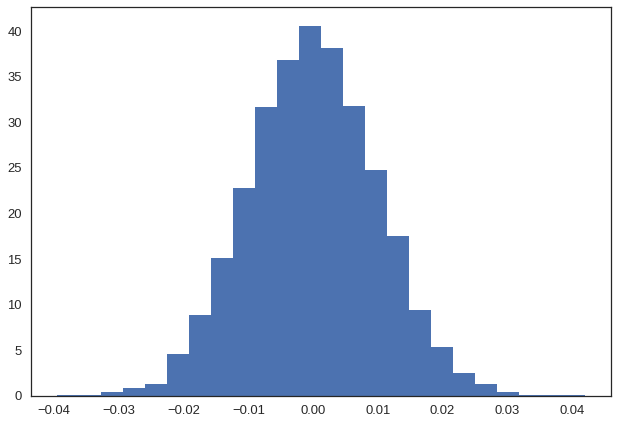

In [23]:
# Positions (rows) of the data we want to make stochastic
ids = range(2,12)

# List with the stochastic parameters 
interface_Z_modifier = [pymc.Normal("interface_Z_mod_"+str(i), 0., 1./0.01**2) for i in ids]

# Plotting the first element of the list
samples = [interface_Z_modifier[0].rand() for i in range(10000)]
plt.hist(samples, bins=24, normed=True);

To store the value of the input data---i.e. the value x at every each iteration---we need to wrap the process inside a detereministic decorator of pymc2:

## Deterministic functions

In [25]:
@pymc.deterministic(trace=True)
def input_data(value = 0, 
               interface_Z_modifier = interface_Z_modifier,
               geo_data_stoch_init = geo_data_stoch_init,
               ids = ids,
               verbose=0):
    # First we extract from our original intep_data object the numerical data that is necessary for the interpolation.
    # geo_data_stoch is a pandas Dataframe
    geo_data_stoch = gp.get_data(geo_data_stoch_init, numeric=True)
    
    # Now we loop each id which share the same uncertainty variable. In this case, each layer.
    for num, i in enumerate(ids):
        # We add the stochastic part to the initial value
        interp_data.geo_data_res.interfaces.set_value(i, "Z", geo_data_stoch_init.interfaces.iloc[i]["Z"] + interface_Z_modifier[num])
        
    if verbose > 0:
        print(geo_data_stoch)
        
    # then return the input data to be input into the modeling function. Due to the way pymc2 stores the traces
    # We need to save the data as numpy arrays
    return [interp_data.geo_data_res.interfaces[["X", "Y", "Z"]].values,
            interp_data.geo_data_res.orientations[["G_x", "G_y", "G_z", "X", "Y", "Z", 'dip', 'azimuth', 'polarity']].values]

In [27]:
# %matplotlib notebook
@pymc.deterministic(trace=False)
def gempy_model(value=0,
                input_data=input_data, verbose=False):
    
    # modify input data values accordingly
    interp_data.geo_data_res.interfaces[["X", "Y", "Z"]] = input_data[0]
    
    # Gx, Gy, Gz are just used for visualization. The theano function gets azimuth dip and polarity!!!
    interp_data.geo_data_res.orientations[["G_x", "G_y", "G_z", "X", "Y", "Z", 'dip', 'azimuth', 'polarity']] = input_data[1]
    
    try:
        # try to compute model
        lb, fb, grav = gp.compute_model(interp_data, output='gravity')
        if verbose:
            gp.plot_section(interp_data.geo_data_res, lb[0], 5, plot_data=False)
           # gp.plot_data(interp_data.geo_data_res, direction='y')

        return lb, fb, grav
    
    except np.linalg.linalg.LinAlgError as err:
        # if it fails (e.g. some input data combinations could lead to 
        # a singular matrix and thus break the chain) return an empty model
        # with same dimensions (just zeros)
        if verbose:
            print("Exception occured.")
        return np.zeros_like(lith), np.zeros_like(fault), np.zeros_like(grav_i)

In [38]:
@pymc.deterministic(trace=True)
def gempy_surfaces(value=0, gempy_model=gempy_model):
    vert, simp = gp.get_surfaces(interp_data, gempy_model[0][1], gempy_model[1][1], original_scale=True)
    
    return vert

In [39]:
@pymc.deterministic(trace=True)
def gempy_topo(value=0, gm=gempy_model, verbose=False):
    G, c, lu, lot1, lot2 = gp.topology_compute(geo_data, gm[0][0], gm[1], cell_number=0, direction="y")
    
    if verbose:
        gp.plot_section(geo_data, gm[0][0], 0)
        gp.topology_plot(geo_data, G, c)
    
    return G, c, lu, lot1, lot2

In [40]:
@pymc.deterministic
def e_sq(value = original_grav, model_grav = gempy_model[2], verbose = 0):
    square_error =  np.sqrt(np.sum((value*10**-7 - (model_grav*10**-7))**2)) 
  #  print(square_error)
    return square_error



## Likelihood functions

In [42]:
@pymc.stochastic
def like_topo_jaccard_cauchy(value=0, gempy_topo=gempy_topo, G=topo_G):
    """Compares the model output topology with a given topology graph G using an inverse Jaccard-index embedded in a half-cauchy likelihood."""
    j = gp.topology.compare_graphs(G, gempy_topo[0])  # jaccard-index comparison
    return pymc.half_cauchy_like(1 - j, 0, 0.001)  # the last parameter adjusts the "strength" of the likelihood

In [43]:
@pymc.observed
def inversion(value = 1, e_sq = e_sq):
    return pymc.half_cauchy_like(e_sq,0,0.1)

## pymc Model

In [44]:
# We add all the pymc objects to a list
params = [input_data, gempy_model, gempy_surfaces, gempy_topo, *interface_Z_modifier,
          like_topo_jaccard_cauchy, e_sq, inversion] 

# We create the pymc model i.e. the probabilistic graph
model = pymc.Model(params)

Create pymc probabilistic graph plot:

In [47]:
graph = pymc.graph.dag(model, path = 'figures/')
graph.write_png('figures/paper_graph_like.png')

True

Running inference:

In [3]:
runner = pymc.MCMC(model, db="hdf5", dbname="pymc-db/paper_like.hdf5")

NameError: name 'pymc' is not defined

In [30]:
#iterations = 1000

In [ ]:
runner.use_step_method(pymc.AdaptiveMetropolis, params, delay=1000)
runner.sample(iter = 20000, burn=1000, thin=20, tune_interval=1000, tune_throughout=True)

Computing the initial model:

In [4]:
post = gp.pa.Posterior("pymc-db/paper_like2.hdf5")

../../gempy/data_management.py:79: UserWarning: path_f is deprecated use instead path_o
  warnings.warn('path_f is deprecated use instead path_o')


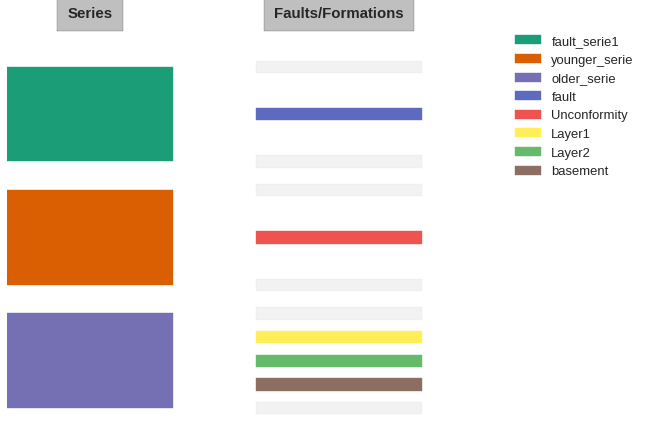

In [65]:
geo_data_p = gp.create_data(#[0,20e3,0, 10e3,-10e3,0],[100,10,100],
                            [-10e3,30e3,-10e3,20e3,-10e3,0],[100,50,50],
                         path_f = "input_data/paper_Orientations.csv",
                         path_i = "input_data/paper_Points.csv")

gp.set_series(geo_data_p, {'fault_serie1': 'fault','younger_serie' : 'Unconformity', 'older_serie': ('Layer1', 'Layer2')},
              order_formations= ['fault', 'Unconformity', 'Layer2', 'Layer1'], verbose=2)


geo_data_p.interfaces[['X', 'Y', 'Z']] = geo_data_p.interfaces[['X', 'Y', 'Z']]*1000
geo_data_p.orientations[['X', 'Y', 'Z']] = geo_data_p.orientations[['X', 'Y', 'Z']]*1000

In [66]:
interp_datap_p = gp.InterpolatorData(geo_data_p, dtype='float64', compile_theano=True)

Compiling theano function...
Compilation Done!
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  1


In [7]:
post.input_data

array([[ array([[0.35883858937874313, 0.5167709833399529, 0.598676107973558],
       [0.5473823096327076, 0.4834290166600472, 0.4293510640755246],
       [0.29074992562074076, 0.5167709833399529, 0.60723489589594681],
       [0.2501, 0.5167709833399529, 0.59794463536585385],
       [0.508227104378227, 0.5167709833399529, 0.54621383558110048],
       [0.7328180251206379, 0.5167709833399529, 0.55932253154279343],
       [0.28261995383337923, 0.5167709833399529, 0.5144562238171192],
       [0.6088357219696087, 0.5167709833399529, 0.47131568531323575],
       [0.7246880533332765, 0.5167709833399529, 0.43200235469532261],
       [0.28770120287146356, 0.5167709833399529, 0.45430032345979277],
       [0.5864782328704313, 0.5167709833399529, 0.42649122888945934],
       [0.7175743113483518, 0.5167709833399529, 0.39705789773081013]], dtype=object),
        array([[0.5158393421069829, 0.5167709833399529, 0.4411541202802112, 39.611,
        90.0, 1],
       [0.5443132816257222, 0.5167709833399529

In [67]:
post.change_input_data(interp_datap_p, 300)

In [68]:
interp_datap_p.update_interpolator()

In [69]:
interp_datap_p.geo_data_res.interfaces.dtypes

X                    float64
Y                    float64
Z                    float64
formation           category
series              category
formation_number       int64
order_series           int64
isFault                 bool
annotations           object
formation_value        int64
dtype: object

In [70]:
interp_data.geo_data_res.interfaces.dtypes

X                    float64
Y                    float64
Z                    float64
formation           category
series              category
formation_number       int64
order_series           int64
isFault                 bool
annotations           object
formation_value        int64
dtype: object

../../gempy/gempy_front.py:927: FutureWarning: gempy plotting functionality will be moved in version 1.2, use gempy.plotting module instead
  warnings.warn("gempy plotting functionality will be moved in version 1.2, use gempy.plotting module instead", FutureWarning)


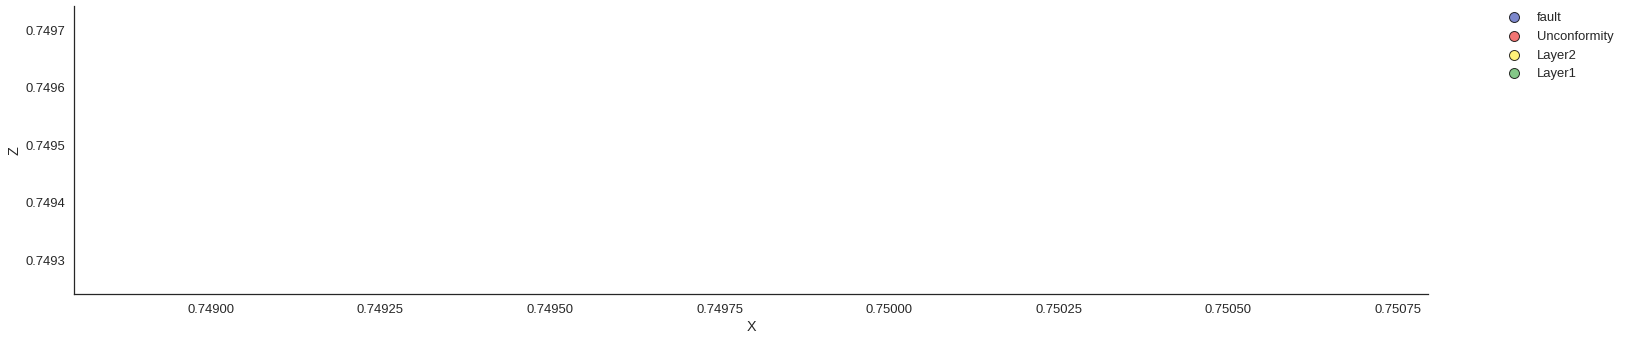

In [73]:
gp.plot_data(interp_datap_p.geo_data_res, data_type='interfaces')

In [37]:
interp_datap_p.get_input_data()

[array([[ 0.51583934,  0.51677098,  0.44115412],
        [ 0.54431328,  0.51677098,  0.58197842],
        [ 0.31208658,  0.51677098,  0.54074657],
        [ 0.7501    ,  0.51677098,  0.46962816]]),
 array([ 39.611,   1.332,  21.448,  36.027]),
 array([  90.,  270.,  270.,   90.]),
 array([ 1.,  1.,  1.,  1.]),
 array([[ 0.35883859,  0.51677098,  0.59867611],
        [ 0.29074993,  0.51677098,  0.61788417],
        [ 0.29074993,  0.51677098,  0.61788417],
        [ 0.29074993,  0.51677098,  0.61788417],
        [ 0.28261995,  0.51677098,  0.50627664],
        [ 0.28261995,  0.51677098,  0.50627664],
        [ 0.2877012 ,  0.51677098,  0.45503913],
        [ 0.2877012 ,  0.51677098,  0.45503913]]),
 array([[ 0.54738231,  0.48342902,  0.42935106],
        [ 0.2501    ,  0.51677098,  0.6005905 ],
        [ 0.5082271 ,  0.51677098,  0.55854283],
        [ 0.73281803,  0.51677098,  0.53663237],
        [ 0.60883572,  0.51677098,  0.45379922],
        [ 0.72468805,  0.51677098,  0.45760529],


In [25]:
gp.plotting.plot_data_3D(interp_datap_p.geo_data_res)

closing vtk


In [74]:
lb_p, fb_p = gp.compute_model(interp_datap_p)

ValueError: array must not contain infs or NaNs
Apply node that caused the error: Solve{A_structure='general', lower=False, overwrite_A=False, overwrite_b=False}(Block Covariance Matrix, InplaceDimShuffle{1,0}.0)
Toposort index: 576
Inputs types: [TensorType(float64, matrix), TensorType(float64, col)]
Inputs shapes: [(10, 10), (10, 1)]
Inputs strides: [(80, 8), (8, 8)]
Inputs values: ['not shown', 'not shown']
Inputs type_num: [12, 12]
Outputs clients: [[Shape(Solve{A_structure='general', lower=False, overwrite_A=False, overwrite_b=False}.0), Reshape{1}(Solve{A_structure='general', lower=False, overwrite_A=False, overwrite_b=False}.0, MakeVector{dtype='int64'}.0)]]

Backtrace when the node is created(use Theano flag traceback.limit=N to make it longer):
  File "../../gempy/interpolator.py", line 130, in compile_th_fn
    self.interpolator.tg.compute_geological_model(),
  File "../../gempy/theano_graph.py", line 1761, in compute_geological_model
    return_list=True
  File "/home/miguel/anaconda3/lib/python3.6/site-packages/theano/scan_module/scan.py", line 773, in scan
    condition, outputs, updates = scan_utils.get_updates_and_outputs(fn(*args))
  File "../../gempy/theano_graph.py", line 1679, in compute_a_series
    scalar_field_values, scalar_field_contribution = self.block_series()
  File "../../gempy/theano_graph.py", line 1349, in block_series
    Z_x = self.scalar_field_at_all(weights)
  File "../../gempy/theano_graph.py", line 1146, in scalar_field_at_all
    weights = self.extend_dual_kriging()
  File "../../gempy/theano_graph.py", line 715, in extend_dual_kriging
    DK_parameters = self.solve_kriging()
  File "../../gempy/theano_graph.py", line 673, in solve_kriging
    DK_parameters = theano.tensor.slinalg.solve(C_matrix, b2)

Debugprint of the apply node: 
Solve{A_structure='general', lower=False, overwrite_A=False, overwrite_b=False} [id A] <TensorType(float64, col)> ''   
 |IncSubtensor{Set;int64::, int64:int64:} [id B] <TensorType(float64, matrix)> 'Block Covariance Matrix'   
 |InplaceDimShuffle{1,0} [id C] <TensorType(float64, col)> ''   
   |Reshape{2} [id D] <TensorType(float64, row)> ''   
     |InplaceDimShuffle{0,2,1,3} [id E] <TensorType(float64, (True, True, True, False))> ''   
     | |Alloc [id F] <TensorType(float64, (True, True, True, False))> ''   
     |   |IncSubtensor{Set;int64:int64:} [id G] <TensorType(float64, vector)> 'b vector'   
     |   |TensorConstant{1} [id H] <TensorType(int8, scalar)>
     |   |TensorConstant{1} [id H] <TensorType(int8, scalar)>
     |   |TensorConstant{1} [id H] <TensorType(int8, scalar)>
     |   |Subtensor{int64} [id I] <TensorType(int64, scalar)> ''   
     |     |Shape [id J] <TensorType(int64, vector)> ''   
     |     | |IncSubtensor{Set;int64:int64:} [id G] <TensorType(float64, vector)> 'b vector'   
     |     |Constant{0} [id K] <int64>
     |MakeVector{dtype='int64'} [id L] <TensorType(int64, vector)> ''   
       |TensorConstant{1} [id M] <TensorType(int64, scalar)>
       |Elemwise{mul,no_inplace} [id N] <TensorType(int64, scalar)> ''   
         |Subtensor{int64} [id I] <TensorType(int64, scalar)> ''   
         |TensorConstant{1} [id H] <TensorType(int8, scalar)>

HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.
Apply node that caused the error: for{cpu,Looping interfaces}(Elemwise{minimum,no_inplace}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, IncSubtensor{Set;:int64:}.0, IncSubtensor{Set;:int64:}.0, Coordinates of the grid points to interpolate, Length of interfaces in every series, Number of faults, Length of foliations in every series, List with the number of formations, Grade of the universal drift, fault relation matrix, Value of the formation, <TensorType(float64, scalar)>, Range, Covariance at 0, <TensorType(float64, scalar)>, <TensorType(float64, matrix)>, Nugget effect of gradients, Nugget effect of scalar, Number of points per formation accumulative, Value of the formation to compute, Arbitrary scalar to make faults infinite, <TensorType(float64, vector)>, <TensorType(float64, vector)>, Position of the dips, Rest of the points of the layers, Reference points for every layer, Angle of every dip, Azimuth, Polarity)
Toposort index: 66
Inputs types: [TensorType(int64, scalar), TensorType(int32, vector), TensorType(int32, vector), TensorType(int32, vector), TensorType(int32, vector), TensorType(int32, vector), TensorType(int32, vector), TensorType(int32, vector), TensorType(float64, 3D), TensorType(float64, matrix), TensorType(float64, matrix), TensorType(int32, vector), TensorType(int64, scalar), TensorType(int32, vector), TensorType(int32, vector), TensorType(int32, vector), TensorType(int64, matrix), TensorType(int32, vector), TensorType(float64, scalar), TensorType(float64, scalar), TensorType(float64, scalar), TensorType(float64, scalar), TensorType(float64, matrix), TensorType(float64, scalar), TensorType(float64, scalar), TensorType(int32, vector), TensorType(float64, vector), TensorType(int32, vector), TensorType(float64, vector), TensorType(float64, vector), TensorType(float64, matrix), TensorType(float64, matrix), TensorType(float64, matrix), TensorType(float64, vector), TensorType(float64, vector), TensorType(float64, vector)]
Inputs shapes: [(), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (3, 2, 250016), (3, 4), (250016, 3), (4,), (), (4,), (4,), (3,), (3, 3), (5,), (), (), (), (), (9, 250016), (), (), (5,), (5,), (200,), (4,), (4,), (4, 3), (8, 3), (8, 3), (4,), (4,), (4,)]
Inputs strides: [(), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4000256, 2000128, 8), (32, 8), (8, 2000128), (4,), (), (4,), (4,), (4,), (24, 8), (4,), (), (), (), (), (2000128, 8), (), (), (4,), (8,), (4,), (8,), (8,), (8, 32), (8, 64), (8, 64), (8,), (8,), (8,)]
Inputs values: [array(2), array([1, 4], dtype=int32), array([4, 8], dtype=int32), array([1, 2], dtype=int32), array([2, 4], dtype=int32), array([1, 2], dtype=int32), array([2, 4], dtype=int32), array([3, 3], dtype=int32), 'not shown', 'not shown', 'not shown', array([0, 1, 4, 8], dtype=int32), array(1), array([0, 1, 2, 4], dtype=int32), array([0, 1, 2, 4], dtype=int32), array([0, 3, 3], dtype=int32), 'not shown', array([1, 2, 3, 4, 5], dtype=int32), array(2.0), array(0.0025454167378816963), array(1.5426538974972135e-07), array(4.0), 'not shown', array(0.01), array(1e-06), array([0, 1, 4, 6, 8], dtype=int32), array([ 1.,  2.,  3.,  4.,  5.]), 'not shown', array([ 0.,  0.,  0.,  0.]), array([ 0.,  0.,  0.,  0.]), 'not shown', 'not shown', 'not shown', array([ 39.611,   1.332,  21.448,  36.027]), array([  90.,  270.,  270.,   90.]), array([ 1.,  1.,  1.,  1.])]
Inputs type_num: [7, 5, 5, 5, 5, 5, 5, 5, 12, 12, 12, 5, 7, 5, 5, 5, 7, 5, 12, 12, 12, 12, 12, 12, 12, 5, 12, 5, 12, 12, 12, 12, 12, 12, 12, 12]
Outputs clients: [[Subtensor{int64::}(for{cpu,Looping interfaces}.0, Constant{1})], [Subtensor{int64::}(for{cpu,Looping interfaces}.1, Constant{1})]]

Backtrace when the node is created(use Theano flag traceback.limit=N to make it longer):
  File "/home/miguel/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/miguel/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/miguel/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/miguel/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-66-eb956c9e94f0>", line 1, in <module>
    interp_datap_p = gp.InterpolatorData(geo_data_p, dtype='float64', compile_theano=True)
  File "../../gempy/interpolator.py", line 102, in __init__
    self.th_fn = self.compile_th_fn(output, **kwargs)
  File "../../gempy/interpolator.py", line 130, in compile_th_fn
    self.interpolator.tg.compute_geological_model(),
  File "../../gempy/theano_graph.py", line 1761, in compute_geological_model
    return_list=True

Debugprint of the apply node: 
for{cpu,Looping interfaces}.0 [id A] <TensorType(float64, 3D)> ''   
 |Elemwise{minimum,no_inplace} [id B] <TensorType(int64, scalar)> ''   
 | |Elemwise{minimum,no_inplace} [id C] <TensorType(int64, scalar)> ''   
 | | |Elemwise{minimum,no_inplace} [id D] <TensorType(int64, scalar)> ''   
 | | | |Elemwise{minimum,no_inplace} [id E] <TensorType(int64, scalar)> ''   
 | | | | |Elemwise{minimum,no_inplace} [id F] <TensorType(int64, scalar)> ''   
 | | | | | |Elemwise{minimum,no_inplace} [id G] <TensorType(int64, scalar)> ''   
 | | | | | | |Subtensor{int64} [id H] <TensorType(int64, scalar)> ''   
 | | | | | | | |Shape [id I] <TensorType(int64, vector)> ''   
 | | | | | | | | |Subtensor{int64:int64:} [id J] <TensorType(int32, vector)> ''   
 | | | | | | | |   |Subtensor{int64::} [id K] <TensorType(int32, vector)> ''   
 | | | | | | | |   | |Length of interfaces in every series [id L] <TensorType(int32, vector)>
 | | | | | | | |   | |ScalarFromTensor [id M] <int64> ''   
 | | | | | | | |   |   |Number of faults [id N] <TensorType(int64, scalar)>
 | | | | | | | |   |Constant{0} [id O] <int64>
 | | | | | | | |   |Constant{-1} [id P] <int64>
 | | | | | | | |Constant{0} [id O] <int64>
 | | | | | | |Subtensor{int64} [id Q] <TensorType(int64, scalar)> ''   
 | | | | | |   |Shape [id R] <TensorType(int64, vector)> ''   
 | | | | | |   | |Subtensor{int64::} [id S] <TensorType(int32, vector)> ''   
 | | | | | |   |   |Subtensor{int64::} [id K] <TensorType(int32, vector)> ''   
 | | | | | |   |   |Constant{1} [id T] <int64>
 | | | | | |   |Constant{0} [id O] <int64>
 | | | | | |Subtensor{int64} [id U] <TensorType(int64, scalar)> ''   
 | | | | |   |Shape [id V] <TensorType(int64, vector)> ''   
 | | | | |   | |Subtensor{int64:int64:} [id W] <TensorType(int32, vector)> ''   
 | | | | |   |   |Subtensor{int64::} [id X] <TensorType(int32, vector)> ''   
 | | | | |   |   | |Length of foliations in every series [id Y] <TensorType(int32, vector)>
 | | | | |   |   | |ScalarFromTensor [id M] <int64> ''   
 | | | | |   |   |Constant{0} [id O] <int64>
 | | | | |   |   |Constant{-1} [id P] <int64>
 | | | | |   |Constant{0} [id O] <int64>
 | | | | |Subtensor{int64} [id Z] <TensorType(int64, scalar)> ''   
 | | | |   |Shape [id BA] <TensorType(int64, vector)> ''   
 | | | |   | |Subtensor{int64::} [id BB] <TensorType(int32, vector)> ''   
 | | | |   |   |Subtensor{int64::} [id X] <TensorType(int32, vector)> ''   
 | | | |   |   |Constant{1} [id T] <int64>
 | | | |   |Constant{0} [id O] <int64>
 | | | |Subtensor{int64} [id BC] <TensorType(int64, scalar)> ''   
 | | |   |Shape [id BD] <TensorType(int64, vector)> ''   
 | | |   | |Subtensor{int64:int64:} [id BE] <TensorType(int32, vector)> ''   
 | | |   |   |Subtensor{int64::} [id BF] <TensorType(int32, vector)> ''   
 | | |   |   | |List with the number of formations [id BG] <TensorType(int32, vector)>
 | | |   |   | |ScalarFromTensor [id M] <int64> ''   
 | | |   |   |Constant{0} [id O] <int64>
 | | |   |   |Constant{-1} [id P] <int64>
 | | |   |Constant{0} [id O] <int64>
 | | |Subtensor{int64} [id BH] <TensorType(int64, scalar)> ''   
 | |   |Shape [id BI] <TensorType(int64, vector)> ''   
 | |   | |Subtensor{int64::} [id BJ] <TensorType(int32, vector)> ''   
 | |   |   |Subtensor{int64::} [id BF] <TensorType(int32, vector)> ''   
 | |   |   |Constant{1} [id T] <int64>
 | |   |Constant{0} [id O] <int64>
 | |Subtensor{int64} [id BK] <TensorType(int64, scalar)> ''   
 |   |Shape [id BL] <TensorType(int64, vector)> ''   
 |   | |Subtensor{int64::} [id BM] <TensorType(int32, vector)> ''   
 |   |   |Subtensor{int64::} [id BN] <TensorType(int32, vector)> ''   
 |   |   | |Grade of the universal drift [id BO] <TensorType(int32, vector)>
 |   |   | |ScalarFromTensor [id M] <int64> ''   
 |   |   |Constant{0} [id O] <int64>
 |   |Constant{0} [id O] <int64>
 |Subtensor{:int64:} [id BP] <TensorType(int32, vector)> ''   
 | |Subtensor{int64:int64:} [id J] <TensorType(int32, vector)> ''   
 | |ScalarFromTensor [id BQ] <int64> ''   
 |   |Elemwise{minimum,no_inplace} [id B] <TensorType(int64, scalar)> ''   
 |Subtensor{:int64:} [id BR] <TensorType(int32, vector)> ''   
 | |Subtensor{int64::} [id S] <TensorType(int32, vector)> ''   
 | |ScalarFromTensor [id BQ] <int64> ''   
 |Subtensor{:int64:} [id BS] <TensorType(int32, vector)> ''   
 | |Subtensor{int64:int64:} [id W] <TensorType(int32, vector)> ''   
 | |ScalarFromTensor [id BQ] <int64> ''   
 |Subtensor{:int64:} [id BT] <TensorType(int32, vector)> ''   
 | |Subtensor{int64::} [id BB] <TensorType(int32, vector)> ''   
 | |ScalarFromTensor [id BQ] <int64> ''   
 |Subtensor{:int64:} [id BU] <TensorType(int32, vector)> ''   
 | |Subtensor{int64:int64:} [id BE] <TensorType(int32, vector)> ''   
 | |ScalarFromTensor [id BQ] <int64> ''   
 |Subtensor{:int64:} [id BV] <TensorType(int32, vector)> ''   
 | |Subtensor{int64::} [id BJ] <TensorType(int32, vector)> ''   
 | |ScalarFromTensor [id BQ] <int64> ''   
 |Subtensor{:int64:} [id BW] <TensorType(int32, vector)> ''   
 | |Subtensor{int64::} [id BM] <TensorType(int32, vector)> ''   
 | |ScalarFromTensor [id BQ] <int64> ''   
 |IncSubtensor{Set;:int64:} [id BX] <TensorType(float64, 3D)> ''   
 | |AllocEmpty{dtype='float64'} [id BY] <TensorType(float64, 3D)> ''   
 | | |Elemwise{add,no_inplace} [id BZ] <TensorType(int64, scalar)> ''   
 | | | |Elemwise{minimum,no_inplace} [id B] <TensorType(int64, scalar)> ''   
 | | | |Subtensor{int64} [id CA] <TensorType(int64, scalar)> ''   
 | | |   |Shape [id CB] <TensorType(int64, vector)> ''   
 | | |   | |Rebroadcast{0} [id CC] <TensorType(float64, 3D)> ''   
 | | |   |   |InplaceDimShuffle{x,0,1} [id CD] <TensorType(float64, (True, False, False))> ''   
 | | |   |     |Alloc [id CE] <TensorType(float64, matrix)> 'final block of lithologies init'   
 | | |   |Constant{0} [id O] <int64>
 | | |Subtensor{int64} [id CF] <TensorType(int64, scalar)> ''   
 | | | |Shape [id CB] <TensorType(int64, vector)> ''   
 | | | |Constant{1} [id T] <int64>
 | | |Subtensor{int64} [id CG] <TensorType(int64, scalar)> ''   
 | |   |Shape [id CB] <TensorType(int64, vector)> ''   
 | |   |Constant{2} [id CH] <int64>
 | |Rebroadcast{0} [id CC] <TensorType(float64, 3D)> ''   
 | |ScalarFromTensor [id CI] <int64> ''   
 |   |Subtensor{int64} [id CA] <TensorType(int64, scalar)> ''   
 |IncSubtensor{Set;:int64:} [id CJ] <TensorType(float64, matrix)> ''   
 | |AllocEmpty{dtype='float64'} [id CK] <TensorType(float64, matrix)> ''   
 | | |Elemwise{add,no_inplace} [id CL] <TensorType(int64, scalar)> ''   
 | | | |Elemwise{minimum,no_inplace} [id B] <TensorType(int64, scalar)> ''   
 | | | |Subtensor{int64} [id CM] <TensorType(int64, scalar)> ''   
 | | |   |Shape [id CN] <TensorType(int64, vector)> ''   
 | | |   | |Rebroadcast{0} [id CO] <TensorType(float64, matrix)> ''   
 | | |   |   |InplaceDimShuffle{x,0} [id CP] <TensorType(float64, row)> ''   
 | | |   |     |<TensorType(float64, vector)> [id CQ] <TensorType(float64, vector)>
 | | |   |Constant{0} [id O] <int64>
 | | |Subtensor{int64} [id CR] <TensorType(int64, scalar)> ''   
 | |   |Shape [id CN] <TensorType(int64, vector)> ''   
 | |   |Constant{1} [id T] <int64>
 | |Rebroadcast{0} [id CO] <TensorType(float64, matrix)> ''   
 | |ScalarFromTensor [id CS] <int64> ''   
 |   |Subtensor{int64} [id CM] <TensorType(int64, scalar)> ''   
 |Coordinates of the grid points to interpolate [id CT] <TensorType(float64, matrix)>
 |Length of interfaces in every series [id L] <TensorType(int32, vector)>
 |Number of faults [id N] <TensorType(int64, scalar)>
 |Length of foliations in every series [id Y] <TensorType(int32, vector)>
 |List with the number of formations [id BG] <TensorType(int32, vector)>
 |Grade of the universal drift [id BO] <TensorType(int32, vector)>
 |fault relation matrix [id CU] <TensorType(int64, matrix)>
 |Value of the formation [id CV] <TensorType(int32, vector)>
 |<TensorType(float64, scalar)> [id CW] <TensorType(float64, scalar)>
 |Range [id CX] <TensorType(float64, scalar)>
 |Covariance at 0 [id CY] <TensorType(float64, scalar)>
 |<TensorType(float64, scalar)> [id CZ] <TensorType(float64, scalar)>
 |<TensorType(float64, matrix)> [id DA] <TensorType(float64, matrix)>
 |Nugget effect of gradients [id DB] <TensorType(float64, scalar)>
 |Nugget effect of scalar [id DC] <TensorType(float64, scalar)>
 |Number of points per formation accumulative [id DD] <TensorType(int32, vector)>
 |Value of the formation to compute [id DE] <TensorType(float64, vector)>
 |Arbitrary scalar to make faults infinite [id DF] <TensorType(int32, vector)>
 |<TensorType(float64, vector)> [id DG] <TensorType(float64, vector)>
 |<TensorType(float64, vector)> [id CQ] <TensorType(float64, vector)>
 |Position of the dips [id DH] <TensorType(float64, matrix)>
 |Rest of the points of the layers [id DI] <TensorType(float64, matrix)>
 |Reference points for every layer [id DJ] <TensorType(float64, matrix)>
 |Angle of every dip [id DK] <TensorType(float64, vector)>
 |Azimuth [id DL] <TensorType(float64, vector)>
 |Polarity [id DM] <TensorType(float64, vector)>
for{cpu,Looping interfaces}.1 [id A] <TensorType(float64, matrix)> ''   

Inner graphs of the scan ops:

for{cpu,Looping interfaces}.0 [id A] <TensorType(float64, 3D)> ''   
 >IncSubtensor{Set;int64, int64::} [id DN] <TensorType(float64, matrix)> ''   
 > |AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=True} [id DO] <TensorType(float64, matrix)> ''   
 > | |IncSubtensor{Set;int64, int64::} [id DP] <TensorType(float64, matrix)> ''   
 > | | |AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=True} [id DQ] <TensorType(float64, matrix)> ''   
 > | | | |final block of lithologies init[t-1] [id DR] <TensorType(float64, matrix)> -> [id BX]
 > | | | |Sum{axis=[0], acc_dtype=float64} [id DS] <TensorType(float64, vector)> 'The chunk of block model of a specific series'   
 > | | | |TensorConstant{0} [id DT] <TensorType(int64, scalar)>
 > | | | |Subtensor{int64} [id DU] <TensorType(int64, vector)> 'Yet simulated LITHOLOGY node'   
 > | | |TensorConstant{0} [id DV] <TensorType(int8, scalar)>
 > | | |Constant{0} [id DW] <int64>
 > | | |ScalarFromTensor [id DX] <int64> ''   
 > | |   |Elemwise{mul,no_inplace} [id DY] <TensorType(int64, scalar)> ''   
 > | |     |TensorConstant{-2} [id DZ] <TensorType(int8, scalar)>
 > | |     |Subtensor{int64} [id EA] <TensorType(int64, scalar)> ''   
 > | |       |Shape [id EB] <TensorType(int64, vector)> ''   
 > | |       | |Reference points for every layer_copy [id EC] <TensorType(float64, matrix)> -> [id DJ]
 > | |       |Constant{0} [id DW] <int64>
 > | |Subtensor{int64} [id ED] <TensorType(float32, vector)> 'Value of the potential field at every point'   
 > | |TensorConstant{1} [id EE] <TensorType(int64, scalar)>
 > | |Subtensor{int64} [id DU] <TensorType(int64, vector)> 'Yet simulated LITHOLOGY node'   
 > |TensorConstant{0} [id DV] <TensorType(int8, scalar)>
 > |Constant{1} [id EF] <int64>
 > |ScalarFromTensor [id DX] <int64> ''   
 >AdvancedIncSubtensor1{no_inplace,set} [id EG] <TensorType(float64, vector)> ''   
 > |<TensorType(float64, vector)> [id EH] <TensorType(float64, vector)> -> [id CQ]
 > |AdvancedSubtensor1 [id EI] <TensorType(float32, vector)> ''   
 > | |Subtensor{int64:int64:} [id EJ] <TensorType(float32, vector)> ''   
 > | | |Subtensor{int64} [id ED] <TensorType(float32, vector)> 'Value of the potential field at every point'   
 > | | |ScalarFromTensor [id DX] <int64> ''   
 > | | |ScalarFromTensor [id EK] <int64> ''   
 > | |   |Elemwise{neg,no_inplace} [id EL] <TensorType(int64, scalar)> ''   
 > | |     |Subtensor{int64} [id EA] <TensorType(int64, scalar)> ''   
 > | |Subtensor{int32:int32:} [id EM] <TensorType(int32, vector)> ''   
 > |   |Number of points per formation accumulative_copy [id EN] <TensorType(int32, vector)> -> [id DD]
 > |   |ScalarFromTensor [id EO] <int32> ''   
 > |   | |<TensorType(int32, scalar)> [id EP] <TensorType(int32, scalar)> -> [id BU]
 > |   |ScalarFromTensor [id EQ] <int32> ''   
 > |     |<TensorType(int32, scalar)> [id ER] <TensorType(int32, scalar)> -> [id BV]
 > |Elemwise{sub,no_inplace} [id ES] <TensorType(int32, vector)> ''   
 >   |Subtensor{int32:int32:} [id ET] <TensorType(int32, vector)> ''   
 >   | |Value of the formation_copy [id EU] <TensorType(int32, vector)> -> [id CV]
 >   | |ScalarFromTensor [id EO] <int32> ''   
 >   | |ScalarFromTensor [id EQ] <int32> ''   
 >   |TensorConstant{(1,) of 1} [id EV] <TensorType(int8, (True,))>

for{cpu,Looping interfaces}.1 [id A] <TensorType(float64, matrix)> ''   
 >IncSubtensor{Set;int64, int64::} [id DN] <TensorType(float64, matrix)> ''   
 >AdvancedIncSubtensor1{no_inplace,set} [id EG] <TensorType(float64, vector)> ''   

Storage map footprint:
 - <TensorType(float64, matrix)>, Shared Input, Shape: (9, 250016), ElemSize: 8 Byte(s), TotalSize: 18001152 Byte(s)
 - IncSubtensor{Set;:int64:}.0, Shape: (3, 2, 250016), ElemSize: 8 Byte(s), TotalSize: 12000768 Byte(s)
 - for{cpu,Looping interfaces}.0, Shape: (3, 2, 250016), ElemSize: 8 Byte(s), TotalSize: 12000768 Byte(s)
 - Coordinates of the grid points to interpolate, Shared Input, Shape: (250016, 3), ElemSize: 8 Byte(s), TotalSize: 6000384 Byte(s)
 - final block of lithologies init, Shape: (2, 250016), ElemSize: 8 Byte(s), TotalSize: 4000256 Byte(s)
 - Arbitrary scalar to make faults infinite, Shared Input, Shape: (200,), ElemSize: 4 Byte(s), TotalSize: 800 Byte(s)
 - Reference points for every layer, Input, Shape: (8, 3), ElemSize: 8 Byte(s), TotalSize: 192 Byte(s)
 - Rest of the points of the layers, Input, Shape: (8, 3), ElemSize: 8 Byte(s), TotalSize: 192 Byte(s)
 - Position of the dips, Input, Shape: (4, 3), ElemSize: 8 Byte(s), TotalSize: 96 Byte(s)
 - IncSubtensor{Set;:int64:}.0, Shape: (3, 4), ElemSize: 8 Byte(s), TotalSize: 96 Byte(s)
 - for{cpu,Looping interfaces}.1, Shape: (3, 4), ElemSize: 8 Byte(s), TotalSize: 96 Byte(s)
 - fault relation matrix, Shared Input, Shape: (3, 3), ElemSize: 8 Byte(s), TotalSize: 72 Byte(s)
 - Value of the formation to compute, Shared Input, Shape: (5,), ElemSize: 8 Byte(s), TotalSize: 40 Byte(s)
 - Angle of every dip, Input, Shape: (4,), ElemSize: 8 Byte(s), TotalSize: 32 Byte(s)
 - Azimuth, Input, Shape: (4,), ElemSize: 8 Byte(s), TotalSize: 32 Byte(s)
 - Polarity, Input, Shape: (4,), ElemSize: 8 Byte(s), TotalSize: 32 Byte(s)
 - <TensorType(float64, vector)>, Shared Input, Shape: (4,), ElemSize: 8 Byte(s), TotalSize: 32 Byte(s)
 - <TensorType(float64, vector)>, Shared Input, Shape: (4,), ElemSize: 8 Byte(s), TotalSize: 32 Byte(s)
 - Value of the formation, Shared Input, Shape: (5,), ElemSize: 4 Byte(s), TotalSize: 20 Byte(s)
 - Number of points per formation accumulative, Shared Input, Shape: (5,), ElemSize: 4 Byte(s), TotalSize: 20 Byte(s)
 - Length of interfaces in every series, Shared Input, Shape: (4,), ElemSize: 4 Byte(s), TotalSize: 16 Byte(s)
 - Length of foliations in every series, Shared Input, Shape: (4,), ElemSize: 4 Byte(s), TotalSize: 16 Byte(s)
 - List with the number of formations, Shared Input, Shape: (4,), ElemSize: 4 Byte(s), TotalSize: 16 Byte(s)
 - Grade of the universal drift, Shared Input, Shape: (3,), ElemSize: 4 Byte(s), TotalSize: 12 Byte(s)
 - Number of faults, Shared Input, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - <TensorType(float64, scalar)>, Shared Input, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Range, Shared Input, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Covariance at 0, Shared Input, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - <TensorType(float64, scalar)>, Shared Input, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Nugget effect of gradients, Shared Input, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Nugget effect of scalar, Shared Input, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{1}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{-1}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{minimum,no_inplace}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Subtensor{int64}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{0.0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{2}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Subtensor{:int64:}.0, Shape: (2,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - Subtensor{:int64:}.0, Shape: (2,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - Subtensor{:int64:}.0, Shape: (2,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - Subtensor{:int64:}.0, Shape: (2,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - Subtensor{:int64:}.0, Shape: (2,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - Subtensor{:int64:}.0, Shape: (2,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - Subtensor{:int64:}.0, Shape: (2,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - TensorConstant{-2}, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 - TensorConstant{2}, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 - TensorConstant{1}, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 - TensorConstant{0}, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 TotalSize: 52005344.0 Byte(s) 0.048 GB
 TotalSize inputs: 24003288.0 Byte(s) 0.022 GB



In [ ]:
gp.plot_section(interp_datap_p.geo_data_res, lb_p[0], 5, plot_data=True)

In [139]:
post.n_iter = 949

In [133]:
v_l, s_l = gp.get_surfaces(interp_datap_p, lb_p[1], fb_p[1], original_scale=True)

In [140]:
ver, sim = gp.get_surfaces(interp_datap_p,lb_p[1], fb_p[1], original_scale= False)
gp.plot_surfaces_3D_real_time(interp_datap_p, ver, sim, posterior=post, alpha=1)

In [77]:
gp.plot_surfaces_3D(geo_data, v_l, s_l, alpha=1)

In [163]:
lith_list = np.zeros((0, lb_p[0].shape[-1]), dtype='int')
vertices_list = []

for i in range(post.n_iter):
    post.change_input_data(interp_datap_p, i)
    lb_p, fb_p = gp.compute_model(interp_datap_p)
    lith_list = np.vstack((lith_list,lb_p[0]))
    v_l, s_l = gp.get_surfaces(interp_datap_p, lb_p[1], fb_p[1], original_scale=True)
    vertices_list.append(v_l)

In [43]:
vertices = post.db.trace("gempy_surfaces")[:]


In [165]:
vertices = vertices_list

Reading traces:

In [186]:
# Some plotting options
params = {
    'axes.labelsize': 6,
    'font.size': 6,
    'legend.fontsize': 10,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6,
    'text.usetex': False,
    "axes.linewidth": 0.75,
    'xtick.major.size': 2,
    'xtick.major.width': 0.75,
    'ytick.major.size': 2,
    'ytick.major.width': 0.75,
}


def get_figsize(scale, textwidth=522, ratio=None):                      # Get this from LaTeX using \the\textwidth
    """Source: http://bkanuka.com/articles/native-latex-plots/"""
    inches_per_pt = 1.0 / 72.27                             # Convert pt to inch
    if ratio == None:
        ratio = (np.sqrt(5.0)-1.0)/2.0                    # Aesthetic ratio (you could change this)
    fig_width = textwidth * inches_per_pt * scale           # width in inches
    fig_height = fig_width * ratio                    # height in inches
    fig_size = [fig_width, fig_height]
    return fig_size

from matplotlib import rcParams
rcParams.update(params)

In [199]:
# Choosing vertices to plot
np.array(vertices[0][1][:,1] > 4800) * np.array(vertices[0][1][:,1] < 5200)

array([False, False, False, ..., False, False, False], dtype=bool)

In [200]:
# Function to plot the traces with the vertices
def plot_iterline(i, l, color="black", lw=0.5):
 
    f = np.array(vertices[i][l][:,1] > 4800) * np.array(vertices[i][l][:,1] < 5200)
    points = vertices[i][l][f]
    plt.plot(points[::3,0], points[::3,2], '-',
             linewidth=lw, color=color, alpha=0.05)


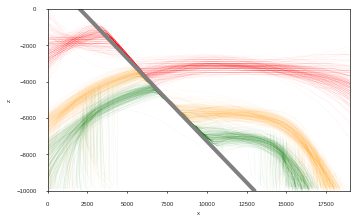

In [209]:
fig = plt.figure(figsize=get_figsize(0.75))
ax = plt.subplot()
    
for i in range(0,950,5):
    plot_iterline(i, 3, color="green")
    plot_iterline(i, 2, color="orange")
    plot_iterline(i, 1, color="red")
    # plot_iterline(i, 0, color="black", lw=2)
    
ax.set_xlabel("x")

plt.legend()
plt.ylabel("z")
plt.xlim(0,19000)
#ax.set_xticks(np.arange(0, 20, 5))
plt.ylim(-10000,-0)
plt.plot([2000., 13000], [0,-10000], color="gray", linewidth=4)
plt.grid(False)

# plt.savefig("doc/figs/like.pdf", facecolor="white")

In [ ]:
gp.plot_section(geo_data, runner.trace("gempy_model")[:][:,0,0,:][2], 5)

In [202]:
p_i = uq.compute_prob_lith(lith_list)

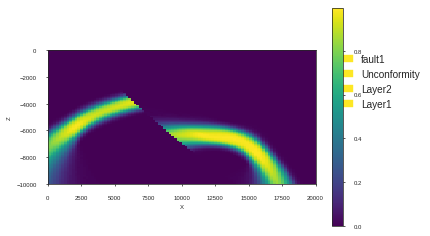

In [208]:
gp.plot_section(geo_data_p,p_i[3], 5, cmap='viridis', norm=None)
plt.colorbar()

#plt.savefig("doc/figs/prob.pdf", facecolor="white")

In [205]:
e = gp.pa.calcualte_ie_masked(p_i)

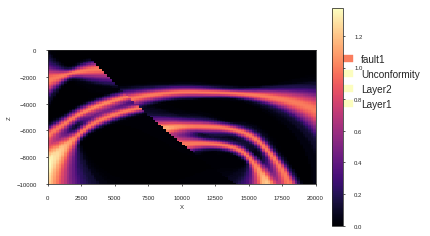

In [206]:
gp.plot_section(geo_data_p,e, 5, cmap='magma', norm=None)
plt.colorbar()
#plt.savefig("doc/figs/entropy.pdf", facecolor="white")